# How to use EarthDataLab.jl to do large scale computations

* This notebook is available at https://github.com/JuliaDataCubes/ESDLTutorials

## NFDI4Earth

- National Research Data Infrastructure in Germany
- FAIR Data Access
- Cultural shift in  Earth System sciences towards openness
- Provide a one-stop access point and a user support network


## Why Julia?

* Scripting and High Performance in the same language
* Multiple Dispatch
* Introspection into other peoples code

## Load the relevant packages

In [1]:
]activate .

  Activating project at `~/Documents/ESDLTutorials`


In [2]:
using EarthDataLab

In [3]:
using Pkg

In [6]:
using Statistics

In [7]:
using Plots

In [8]:
using ESDLPlots

WebIO._IJuliaInit()

In [9]:
using Dates

In [10]:
using YAXArrays

In [11]:
using WeightedOnlineStats

## Use data larger than RAM
* Uses *DiskArrays.jl* in the background
* Load only the data that is really needed
* Use chunks of the data
* Use NetCDF or Zarr or GDAL to load data
* Load data locally or from the cloud

In [12]:
# Do not run, this is only an example

# using Zarr
# cube = Cube("../somepath.zarr");

In [13]:
c = esdc(res="low")

┌ Warning: In the future, fill values will not be interpreted as missing values by default. 
│ Please set the keyword argument `fill_as_missing` to a boolean accordingly. Setting to `true`
│ for now, but in the future `false` will be the default.
└ @ Zarr /home/fcremer/.julia/packages/Zarr/tmr2s/src/metadata.jl:182


YAXArray with the following dimensions
lon                 Axis with 1440 Elements from -179.875 to 179.875
lat                 Axis with 720 Elements from 89.875 to -89.875
time                Axis with 1840 Elements from 1979-01-05T00:00:00 to 2018-12-31T00:00:00
Variable            Axis with 69 elements: leaf_area_index sensible_heat .. snow_sublimation Rg 
units: W m-2
Total size: 490.37 GB


## Subsets happen lazily

In [14]:
europe = subsetcube(c, region="Europe", time=2000:2016, 
	Variable=["air_temperature_2m", "net_ecosystem", "surface_moisture"])

YAXArray with the following dimensions
lon                 Axis with 172 Elements from -9.875 to 32.875
lat                 Axis with 140 Elements from 69.875 to 35.125
time                Axis with 782 Elements from 2000-01-05T00:00:00 to 2016-12-30T00:00:00
Variable            Axis with 3 elements: air_temperature_2m net_ecosystem_exchange surface_moisture 
units: W m-2
Total size: 215.5 MB


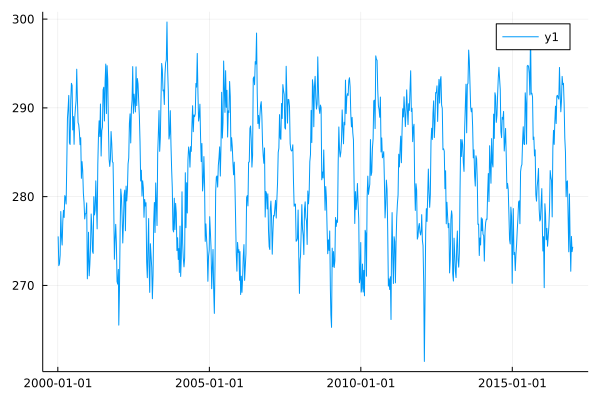

In [15]:
plot(europe.time.values,europe[Variable="air_temperature_2m", lat=50, lon=11].data)

## Make computations on every element of the cube
* Computations are only registered
* Computations are done with other computations together

In [16]:
celsiuscube = map(europe[Variable="air_temperature_2m"]) do x
	x - 273.15
end


YAXArray with the following dimensions
lon                 Axis with 172 Elements from -9.875 to 32.875
lat                 Axis with 140 Elements from 69.875 to 35.125
time                Axis with 782 Elements from 2000-01-05T00:00:00 to 2016-12-30T00:00:00
units: W m-2
Total size: 143.67 MB


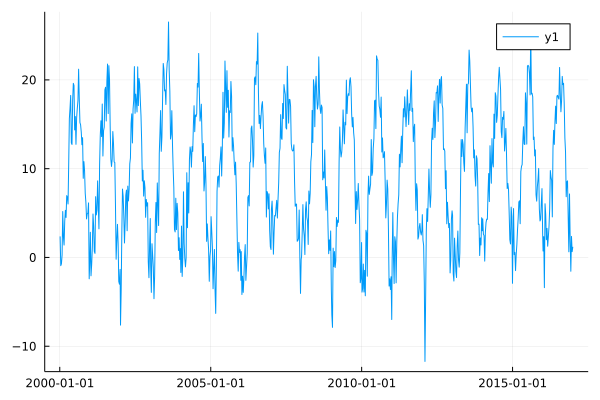

In [17]:
plot(europe.time.values, celsiuscube[lat=50, lon=11].data)

## Make computations along named Axes
* User defined functions
* Use the whole Julia Ecosystem

In [18]:
function prange(pix_prange, pix,threshold)
   	q5, q95 = quantile(pix, [threshold, 1-threshold])
   	pix_prange .=q95 - q5
end

prange (generic function with 1 method)

In [19]:
smalldata = subsetcube(celsiuscube, region="Italy") 
prange_italy = mapCube(prange, smalldata, .05,  indims = InDims("Time"), outdims = OutDims())

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


YAXArray with the following dimensions
lon                 Axis with 48 Elements from 6.625 to 18.375
lat                 Axis with 46 Elements from 46.875 to 35.625
Total size: 17.25 KB


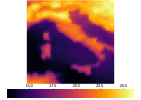

In [20]:
plotMAP(prange_italy)

## Make Moving Window Computations


In [21]:
function movingmean(xout, xin)
    xout .= mean(xin)
end

function movingmean(cube::YAXArray)
    indims = InDims(MovingWindow("lat", 1,1),MovingWindow("lon", 1,1))
    outdims=OutDims()
    mapCube(movingmean, cube; indims=indims, outdims=outdims)
end

movingmean (generic function with 2 methods)

In [22]:
movingavgprange = movingmean(prange_italy)

YAXArray with the following dimensions
lon                 Axis with 48 Elements from 6.625 to 18.375
lat                 Axis with 46 Elements from 46.875 to 35.625
Total size: 17.25 KB


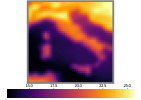

In [23]:
plotMAP(movingavgprange)

## Cube Axes are cubes as well

* Use Cube Axes in the inner functions 
* Combine multiple cubes
* Define the output dimension

In [24]:
using LombScargle

In [25]:
function clombscargle(xout, xin, times)
    ind = .!ismissing.(xin)
    ts = collect(nonmissingtype(eltype(xin)), xin[ind])
    x = times[ind]
    if length(ts) < 10
       @show length(ts)
       xout .= missing
       return
    end
    datediff = Date.(x) .- Date(x[1])
    dateint = getproperty.(datediff, :value)
    pl = LombScargle.plan(dateint, ts)
    pgram = LombScargle.lombscargle(pl)
    lsperiod= findmaxperiod(pgram)
    lspower = findmaxpower(pgram)
    lsnum = LombScargle.M(pgram)
    perval = isempty(lsperiod) ? missing : lsperiod[1]    
    xout .= [lsnum, perval, lspower]
end

clombscargle (generic function with 1 method)

In [26]:
function LombScargle.lombscargle(cube::YAXArray, kwargs...)
    indims = InDims("Time")
    lombax = CategoricalAxis("LombScargle", ["Number of Frequencies", "Period with maximal power", "Maximal Power"])
    #@show cube
    timeax = YAXArrays.getAxis("Time", cube)
    od = OutDims(lombax)
    mapCube(clombscargle, (cube, timeax), indims=(indims, indims), outdims=od)
end

In [27]:
lombitaly = lombscargle(celsiuscube[region="Italy"])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


YAXArray with the following dimensions
LombScargle         Axis with 3 elements: Number of Frequencies Period with maximal power Maximal Power 
lon                 Axis with 48 Elements from 6.625 to 18.375
lat                 Axis with 46 Elements from 46.875 to 35.625
Total size: 51.75 KB


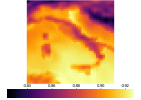

In [28]:
plotMAP(lombitaly[LombScargle="Maximal Power"])

## Load Reference polygons

In [29]:
countrycube = cubefromshape("data/ne_50m_admin_0_countries",europe, labelsym=:NAME)

YAXArray with the following dimensions
lon                 Axis with 172 Elements from -9.875 to 32.875
lat                 Axis with 140 Elements from 69.875 to 35.125
labels: Dict{Int32, String}(55 => "Spain", 32 => "United Kingdom", 219 => "Belarus", 185 => "Czechia", 104 => "Morocco", 62 => "Slovenia", 183 => "Faeroe Is.", 218 => "Belgium", 173 => "Estonia", 235 => "Andorra"…)
Total size: 94.06 KB


## Use table interface
* Use data as a dataframe
* Combine multiple cubes in one table

In [30]:
table = CubeTable(tair=celsiuscube, country=countrycube);#, include_axes=("lon","lat","time"));

## Fit Online Statistics

In [31]:
r = cubefittable(table, WeightedMean, :tair, weight=(i->abs(cosd.(i.lat))), by=(:country,r->month(r.time)))

YAXArray with the following dimensions
Label               Axis with 47 elements: Spain United Kingdom .. Malta Netherlands 
Category2           Axis with 12 elements: 1 2 .. 11 12 
Total size: 4.41 KB


In [32]:
renameaxis!(r, "Category2" => CategoricalAxis("Month", monthname.(1:12)))
renameaxis!(r, "Label"=> "Country")


YAXArray with the following dimensions
Country             Axis with 47 elements: Spain United Kingdom .. Malta Netherlands 
Month               Axis with 12 elements: January February .. November December 
Total size: 4.41 KB


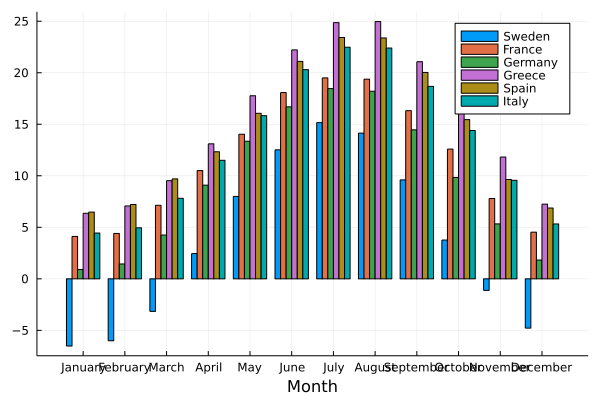

In [33]:
plotXY(r[Country=["Sweden", "France","Germany", "Greece", "Spain", "Italy"]], 
    group="Country", xaxis="Month", label="")

## Use Python Packages
* Use PyCall to have access to the python ecosystem
* Use RCall for R packages

In [34]:
using PyCall

In [35]:
pyimport_conda("scipy.ndimage", "scipy")

PyObject <module 'scipy.ndimage' from '/home/fcremer/.julia/conda/3/lib/python3.9/site-packages/scipy/ndimage/__init__.py'>

In [36]:
scipyndimage = pyimport("scipy.ndimage")

PyObject <module 'scipy.ndimage' from '/home/fcremer/.julia/conda/3/lib/python3.9/site-packages/scipy/ndimage/__init__.py'>

In [37]:
function gaussian_smooth(xout, xin)
    missinds = ismissing.(xin)
    smooth = scipyndimage.gaussian_filter(xin[.!missinds], sigma=4)
    xout[.!missinds] .= smooth
end

gaussian_smooth (generic function with 1 method)

In [38]:
gpp_jena_2010 = c[lat = 50.92878, lon = 11.5899, time = (DateTime(2010), DateTime(2011)), Variable="gross_primary_productivity"]

YAXArray with the following dimensions
time                Axis with 46 Elements from 2010-01-05T00:00:00 to 2010-12-31T00:00:00
units: W m-2
Total size: 184.0 bytes


In [39]:
smoothcube = mapCube(gaussian_smooth, gpp_jena_2010, indims=InDims("time"), outdims=OutDims("time"))

YAXArray with the following dimensions
time                Axis with 46 Elements from 2010-01-05T00:00:00 to 2010-12-31T00:00:00
Total size: 184.0 bytes


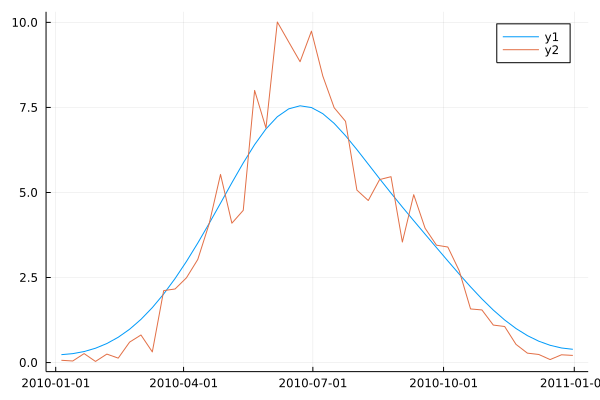

In [40]:
plot(smoothcube.time.values, smoothcube.data)
plot!(gpp_jena_2010.time.values, gpp_jena_2010.data)

In [41]:
@time smoothcube = mapCube(gaussian_smooth, europe, indims=InDims("time"), outdims=OutDims("time"))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


 39.351719 seconds (70.07 M allocations: 5.462 GiB, 5.80% gc time, 13.14% compilation time: 5% of which was recompilation)


YAXArray with the following dimensions
time                Axis with 782 Elements from 2000-01-05T00:00:00 to 2016-12-30T00:00:00
lon                 Axis with 172 Elements from -9.875 to 32.875
lat                 Axis with 140 Elements from 69.875 to 35.125
Variable            Axis with 3 elements: air_temperature_2m net_ecosystem_exchange surface_moisture 
Total size: 215.5 MB


## Easy parallelization on multiple cores and multiple nodes¶
* Use threads on a single computer 
* Use Distributed on multiple computers
* Works also with ClusterManagers like SLURM

Note: This might not work on binder.

In [42]:
using Distributed

In [43]:
addprocs(3) # This doesn't work on Binder, because of memory size

3-element Vector{Int64}:
 2
 3
 4

In [44]:
@everywhere begin
    using Pkg
    Pkg.activate(".")
end

      From worker 3:	  Activating project at `~/Documents/ESDLTutorials`


  Activating project at `~/Documents/ESDLTutorials`


      From worker 2:	  Activating project at `~/Documents/ESDLTutorials`
      From worker 4:	  Activating project at `~/Documents/ESDLTutorials`


In [45]:
@everywhere begin
    using EarthDataLab, Statistics
    function prange(pix_prange, pix,threshold)
        q5, q95 = quantile(pix, [threshold, 1-threshold])
        pix_prange .=q95 - q5
    end
end

In [46]:
@time prangecelsius = mapCube(prange, celsiuscube, .05,  indims = InDims("Time"), outdims = OutDims());

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


 37.576647 seconds (45.12 M allocations: 2.478 GiB, 1.06% gc time, 32.29% compilation time: 1% of which was recompilation)


## Questions ?

## Installation instructions

This shouldn't be needed.

In [47]:
#] add https://github.com/esa-esdl/ESDL.jl/ https://github.com/esa-esdl/ESDLPlots.jl

In [48]:
#]dev --local YAXArrays